<a href="https://colab.research.google.com/github/vhrique/ELF/blob/main/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [104]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Data loading

In [62]:
data_path = '/content/drive/MyDrive/Estudos/Datasets/CMAPSSData'
test_files = list(glob(os.path.join(data_path, 'test_FD00*.txt')))
train_files = list(glob(os.path.join(data_path, 'train_FD00*.txt')))

In [64]:
experiment_columns = ['unit', 'cycle']
condition_columns = [f'cond_{i+1}' for i in range(3)]
feature_columns = [f'sensor_{i+1}' for i in range(21)]
column_names = experiment_columns + condition_columns + feature_columns
dfs = []
for filename in train_files:
    df = pd.read_csv(filename, sep=' ', names=column_names, index_col=False)
    df['group'] = os.path.split(filename)[-1]
    df['RUL'] = None
    df['cycle_max'] = None
    dfs.append(df)
train_df = pd.concat(dfs).reset_index()

<ipython-input-64-bf8aaf388933>:7: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filename, sep=' ', names=column_names, index_col=False)
<ipython-input-64-bf8aaf388933>:7: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filename, sep=' ', names=column_names, index_col=False)
<ipython-input-64-bf8aaf388933>:7: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filename, sep=' ', names=column_names, index_col=False)
<ipython-input-64-bf8aaf388933>:7: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filename, sep=' ', names=column_names, index_col=False)


In [65]:
dfs = []
for filename in test_files:
    df = pd.read_csv(filename, sep=' ', names=column_names, index_col=False)
    df['group'] = os.path.split(filename)[-1]
    df['RUL'] = None
    df['cycle_max'] = None
    dfs.append(df)
test_df = pd.concat(dfs).reset_index()

<ipython-input-65-f329aff9a148>:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filename, sep=' ', names=column_names, index_col=False)
<ipython-input-65-f329aff9a148>:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filename, sep=' ', names=column_names, index_col=False)
<ipython-input-65-f329aff9a148>:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filename, sep=' ', names=column_names, index_col=False)
<ipython-input-65-f329aff9a148>:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filename, sep=' ', names=column_names, index_col=False)


## Adjusting target (RUL)

In [66]:
for group in train_df.group.unique():
    df_group = train_df.query(f'group == "{group}"')
    for unit in df_group.unit.unique():
        df_unit = df_group.query(f'unit == {unit}')
        mask = (train_df.group == group) & (train_df.unit == unit)
        train_df.loc[mask, 'cycle_max'] = df_unit.cycle.max()
train_df.loc[:, 'RUL'] = train_df.cycle_max - train_df.cycle

In [67]:
for group in test_df.group.unique():
    df_group = test_df.query(f'group == "{group}"')
    for unit in df_group.unit.unique():
        df_unit = df_group.query(f'unit == {unit}')
        mask = (test_df.group == group) & (test_df.unit == unit)
        test_df.loc[mask, 'cycle_max'] = df_unit.cycle.max()
test_df.loc[:, 'RUL'] = test_df.cycle_max - test_df.cycle

In [77]:
for group in test_df.group.unique():
    df_group = test_df.query(f'group == "{group}"')
    df_rul = pd.read_csv(
        os.path.join(data_path, group.replace('test', 'RUL')),
        index_col=False, names=['RUL']
    )
    for unit in df_group.unit.unique():
        mask = (test_df.group == group) & (test_df.unit == unit)
        test_df.loc[mask, 'RUL'] = test_df.loc[mask, 'RUL'] + df_rul.RUL[unit-1]

# Exploratory Data Analysis

In [127]:
train_df.describe()

,unit,cycle,cond_1,cond_2,cond_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
count,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,...,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000
mean,105.553758,123.331338,17.211973,0.410004,95.724344,485.840890,597.361022,1467.035653,1260.956434,9.894999,...,338.789821,2349.645243,8088.950972,9.054747,0.025185,360.698801,2273.754039,98.389146,25.942709,15.565700
std,72.867325,83.538146,16.527988,0.367938,12.359044,30.420388,42.478516,118.175261,136.300073,4.265554,...,164.193480,111.167242,80.623257,0.751581,0.004997,31.021430,142.513114,4.656270,11.691422,7.015067
min,1.000000,1.000000,-0.008700,-0.000600,60.000000,445.000000,535.480000,1242.670000,1023.770000,3.910000,...,128.310000,2027.570000,7845.780000,8.156300,0.020000,302.000000,1915.000000,84.930000,10.160000,6.010500
25%,44.000000,57.000000,0.001300,0.000200,100.000000,449.440000,549.960000,1357.360000,1126.830000,5.480000,...,164.790000,2387.970000,8070.530000,8.439250,0.020000,332.000000,2212.000000,100.000000,14.330000,8.601300
50%,89.000000,114.000000,19.998100,0.620000,100.000000,489.050000,605.930000,1492.810000,1271.740000,9.350000,...,321.690000,2388.070000,8118.590000,9.030100,0.030000,367.000000,2319.000000,100.000000,24.920000,14.953500
75%,164.000000,173.000000,35.001500,0.840000,100.000000,518.670000,642.340000,1586.590000,1402.200000,14.620000,...,521.340000,2388.160000,8139.410000,9.344200,0.030000,392.000000,2388.000000,100.000000,38.820000,23.294600
max,260.000000,543.000000,42.008000,0.842000,100.000000,518.670000,645.110000,1616.910000,1441.490000,14.620000,...,537.490000,2390.490000,8293.720000,11.066900,0.030000,400.000000,2388.000000,100.000000,39.890000,23.950500


# Modelling

In [97]:
X_train = train_df.loc[train_df.unit > 10, condition_columns + feature_columns]
y_train = train_df.loc[train_df.unit > 10].RUL

X_val = train_df.loc[train_df.unit <= 10, condition_columns + feature_columns]
y_val = train_df.loc[train_df.unit <= 10].RUL

X_test = test_df[condition_columns + feature_columns]
y_test = test_df.RUL

In [98]:
mdl = RandomForestRegressor(max_samples=10_000).fit(X_train, y_train)

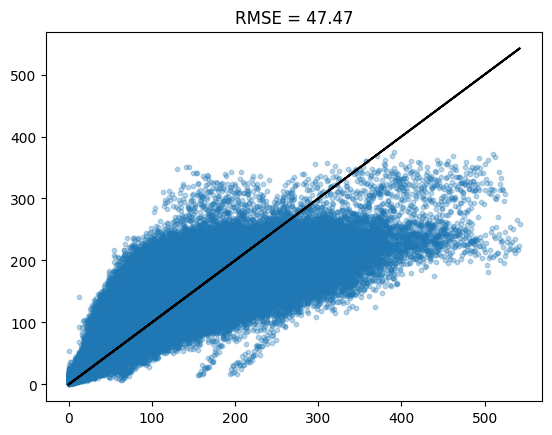

In [128]:
yh_train = mdl.predict(X_train)
plt.scatter(y_train, yh_train, s=10, alpha=0.3)
plt.plot(y_train, y_train, 'k')
plt.title(f'RMSE = {np.sqrt(mean_squared_error(y_train, yh_train)):.2f}')
plt.show()

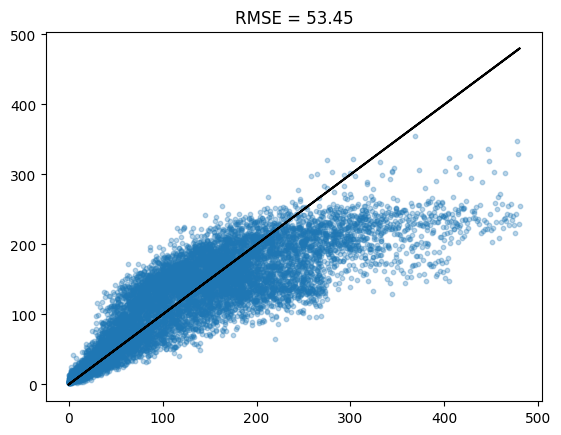

In [106]:
yh_val = mdl.predict(X_val)
plt.scatter(y_val, yh_val, s=10, alpha=0.3)
plt.plot(y_val, y_val, 'k')
plt.title(f'RMSE = {np.sqrt(mean_squared_error(y_val, yh_val)):.2f}')
plt.show()

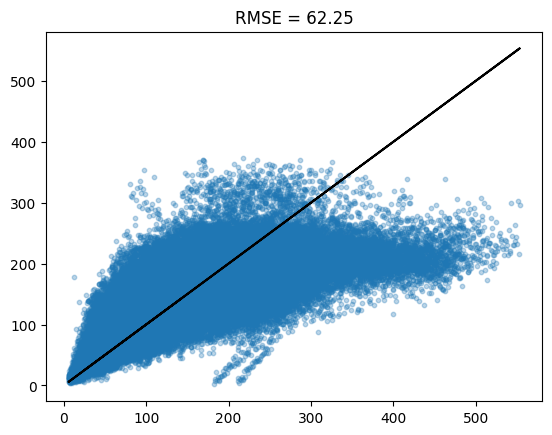

In [105]:
yh_test = mdl.predict(X_test)
plt.scatter(y_test, yh_test, s=10, alpha=0.3)
plt.plot(y_test, y_test, 'k')
plt.title(f'RMSE = {np.sqrt(mean_squared_error(y_test, yh_test)):.2f}')
plt.show()

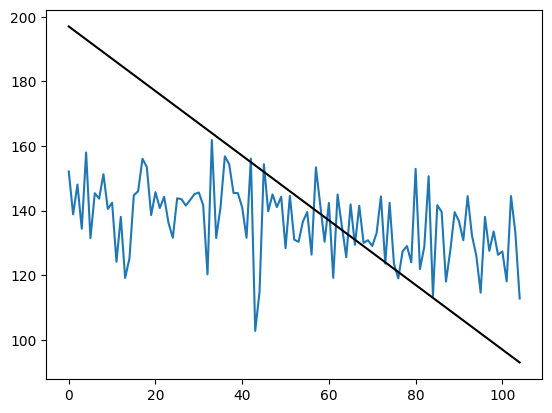

In [123]:
group = test_df.group.unique()[0]
example_df = test_df.query(f'group == "{group}" and unit == 6')

yh_example = mdl.predict(example_df[condition_columns + feature_columns])
plt.plot(yh_example)
plt.plot(example_df.RUL.to_list(), 'k')
plt.show()